In [712]:
import os
import sys
import cv2
import importlib
import matplotlib.pyplot as plt

ROOT_DIR = os.path.abspath(".")

sys.path.append(ROOT_DIR)

In [713]:
import numpy as np
import math
import mrcnn.model as modellib

import Bar3_12


import Bar3_12.ICRNConfigure
from mrcnn.config import Config

from Bar3_12.Dataset_generator import GenerateOneBarChart

In [714]:
Bar3_12.ICRNConfigure.MakeDir('testDataset')
Bar3_12.ICRNConfigure.ClearDir('testDataset')

Resetting the folder..... testDataset


In [715]:
class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "CQA"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
maskrcnnconfig = ShapesConfig()
maskrcnnconfig.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 8
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [5]:
RCNNMODEL_DIR = os.path.join(ROOT_DIR, "MaskRCNNlogs/BarChart_color/logs_bargrayscale")

In [6]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
maskrcnn_model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=RCNNMODEL_DIR)

maskrcnn_model_path = maskrcnn_model.find_last()

# Load trained weights
print("Loading weights from ", maskrcnn_model_path)
maskrcnn_model.load_weights(maskrcnn_model_path, by_name=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loading weights from  /home/mahsa.geshvadi001/projects/PaperCodes/2_Comparison/Instance-based-RN/Codes_PureExperiment_default_5_times/Task1_ourNewTasks/MaskRCNNlogs/BarChart_color/logs_bargrayscale/cqa20230330T1943/mask_rcnn_cqa_0060.h5


2023-03-30 22:14:09.471173: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2023-03-30 22:14:09.501044: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3000000000 Hz
2023-03-30 22:14:09.503740: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x112ed8e0 executing computations on platform Host. Devices:
2023-03-30 22:14:09.503782: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): Host, Default Version


Re-starting from epoch 60


In [113]:
image_num = 1
min_num_obj = 3
max_num_obj = 6

In [114]:
def get_segmented_image_crop(x1, y1, x2, y2, image):
    
    segment = image[x1: y1, x2 : y2]
    new_image = np.ones(shape=(image.shape[0], image.shape[1], image.shape[2]))
    new_image[x1: y1, x2 : y2] = segment
    return new_image

In [260]:
def get_segmented_image(segments_bbs, image):
    
    padding = 2
    removed_image = image.copy()
    for i in range(len(segments_bbs)):
        toremovesegment = segments_bbs[i]
    
        x1 = toremovesegment[0]
        y1  = toremovesegment[2]
 
        x2 = toremovesegment[1]
        y2 = toremovesegment[3]

        y1 = 100
        removed_image[0 : y1, x2-padding : y2+padding ] = (1, 1, 1)
        removed_image[0 : y1, x2-padding : y2+padding ] =removed_image[0 : y1, x2-padding : y2+padding ] +  np.random.uniform(0, 0.05, (abs(y1), abs(y2-x2 + padding + padding),3))
        _min = 0.0  # because the image is not 0/1 black-and-white image, is a RGB image.
        _max = removed_image.max()
        removed_image -= _min
        removed_image[0 : y1, x2-padding : y2+padding ] /= (_max - _min)
   
    return removed_image

In [272]:
image, _, featureVector = GenerateOneBarChart(
                num=np.random.randint(min_num_obj, max_num_obj + 1))
        
cv2.imwrite('testDataset/' + 'image.png', image * 255)

color_img = np.zeros((image.shape[0], image.shape[1], 3))

color_img[:,:,0] = image[:,:,0]
color_img[:,:,1] = image[:,:,0]
color_img[:,:,2] = image[:,:,0]

image = color_img

results = maskrcnn_model.detect([image], verbose=1)
r = results[0]
arr = r['rois']
segments_bbs = arr[arr[:,1].argsort()]
segments = []
for t in range(len(r['rois'])):
   # segments.append(get_segmented_image(segments_bbs[t][0],segments_bbs[t][2], 
            #                                    segments_bbs[t][1] , segments_bbs[t][3], image))
    segments.append(get_segmented_image([x for x in segments_bbs if ((x != segments_bbs[t]).any())], image))
           

Processing 1 images
image                    shape: (100, 100, 3)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 128, 128, 3)      min: -123.69808  max: -102.90105  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  float64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


In [273]:
segments_bbs

array([[ 47,  11, 100,  31],
       [ 25,  40,  99,  60],
       [ 82,  69, 100,  89]], dtype=int32)

In [274]:
test = image.copy()

In [275]:
test[81: 100, 5: 35] = 1

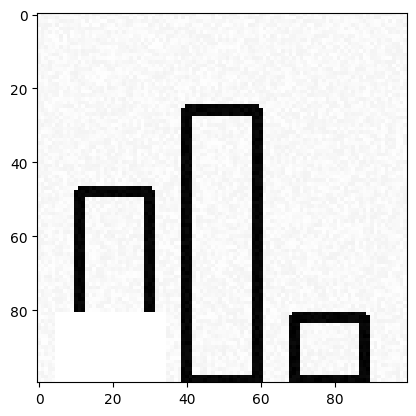

In [276]:
plt.imshow(test)

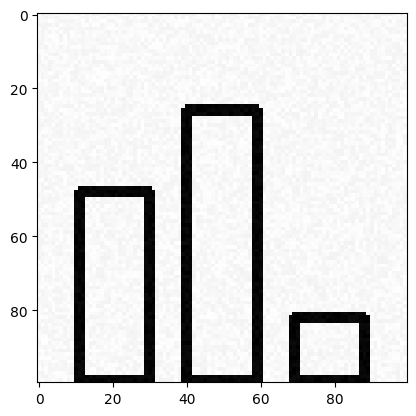

In [277]:
plt.imshow(color_img)

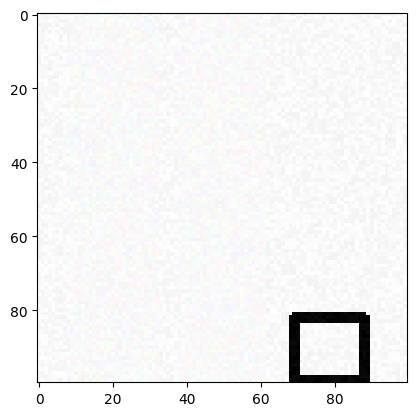

In [281]:
plt.imshow(segments[2])

# Image Processing

In [214]:
_image  = image * 255

In [215]:
ret, thresholed_image = cv2.threshold(_image,25,255,cv2.THRESH_BINARY) # apply threshold to blur image

thresholed_image = thresholed_image.astype(np.uint8)

In [216]:
contours, hierarchy = cv2.findContours(thresholed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # find countour


In [217]:
obj_index = contours.index(max(contours, key=len)) # find index of largest object
contour_img = cv2.drawContours(_image, contours, obj_index, (0,255,0), 3) # draw coutour on original image


/home/mahsa.geshvadi001/.local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


In [218]:
for c in contours:
    rect = cv2.boundingRect(c)

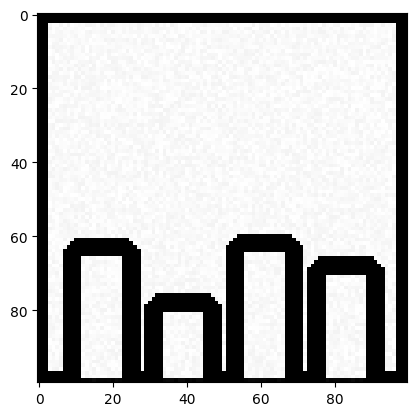

In [219]:
plt.imshow(contour_img, cmap = 'gray')

In [220]:
new_image = np.ones(shape=(_image.shape[0], _image.shape[1], _image.shape[2]))


In [221]:
c = contours[2]

In [222]:
x,y,w,h = cv2.boundingRect(c)

# draw contour
img = cv2.drawContours(_image,[c],0,(0,255,255),2)

# draw the bounding rectangle
img = cv2.rectangle(new_image,(x,y),(x+w,y+h),(0,255,0),2)

In [223]:
def get_segmented_image_processing(c, _image):
    
    new_image = np.ones(shape=(_image.shape[0], _image.shape[1], _image.shape[2]))
    x,y,w,h = cv2.boundingRect(c)

    img = cv2.drawContours(_image,[c],0,(0,255,255),2)

    img = cv2.rectangle(new_image,(x,y),(x+w,y+h),(0,255,0),2)
    
    return img

In [224]:
segments_image_processing = []

for c in contours[:-1]:

    segments_image_processing.append(get_segmented_image_processing(c,_image))
    
#segments_image_processing = segments_image_processing.reverse()           

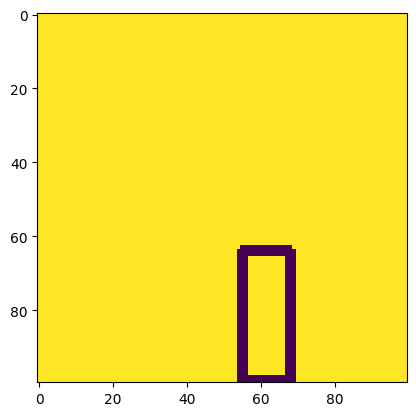

In [228]:
plt.imshow(segments_image_processing[3])